In [1]:
from sympy import *
from sympy.assumptions.assume import global_assumptions

In [2]:
l, t, m1, m2, g = symbols("l t m1 m2 g", real=True, positive=True)
p1x = Function("p1x", real=True)(t)
theta = Function("theta", real=True)(t)
global_assumptions.add(Q.real(theta.diff(t)))
global_assumptions.add(Q.real(p1x.diff(t)))
thetaDot = theta.diff(t, real=True)

In [3]:
p2Vec = Matrix([[p1x - l * sin(theta)],
                [l * cos(theta)]], real=True)
display(p2Vec)

Matrix([
[-l*sin(theta(t)) + p1x(t)],
[          l*cos(theta(t))]])

In [4]:
p1Vec = Matrix([p1x, 0])
display(p1Vec)

Matrix([
[p1x(t)],
[     0]])

In [5]:
p1VecDot = p1Vec.diff(t).norm()
display(p1VecDot)


Abs(Derivative(p1x(t), t))

In [6]:
p2VecDot = simplify(refine(p2Vec.diff(t).norm()))
display(p2VecDot**2)

l**2*Derivative(theta(t), t)**2 - 2*l*cos(theta(t))*Derivative(p1x(t), t)*Derivative(theta(t), t) + Derivative(p1x(t), t)**2

In [7]:
i = m2*l**2 # Using lower case since upper case I is reserved as sqrt(-1) in sympy
ke = 1/2*m1*p1VecDot**2  + 1/2*m2*p2VecDot**2 #+ 1/2*i*thetaDot**2
pe = m2*g*l*cos(theta)
L = simplify(refine(ke - pe))
display(L)

-g*l*m2*cos(theta(t)) + 0.5*m1*Derivative(p1x(t), t)**2 + 0.5*m2*(l**2*Derivative(theta(t), t)**2 - 2*l*cos(theta(t))*Derivative(p1x(t), t)*Derivative(theta(t), t) + Derivative(p1x(t), t)**2)

In [8]:
#  Check if we can account for f(t)
eom1, eom2 = euler_equations(L, [p1x, theta], t)
f = Function("f")
eom1 = eom1.subs(0, -f(t))

In [9]:
display(simplify(eom1))

Eq(f(t), 1.0*m1*Derivative(p1x(t), (t, 2)) + m2*(l*sin(theta(t))*Derivative(theta(t), t)**2 - l*cos(theta(t))*Derivative(theta(t), (t, 2)) + Derivative(p1x(t), (t, 2))))

In [10]:
display(simplify(eom2))

Eq(l*m2*(g*sin(theta(t)) - l*Derivative(theta(t), (t, 2)) + cos(theta(t))*Derivative(p1x(t), (t, 2))), 0)

In [11]:
# Now is a good time to apply our assumptions about the system
eom1 = eom1.subs(sin(theta), theta)
eom1 = eom1.subs(cos(theta), 1)
eom1 = eom1.subs(thetaDot**2, 0)
eom1 = simplify(eom1)

eom2 = eom2.subs(sin(theta), theta)
eom2 = eom2.subs(cos(theta), 1)
eom2 = eom2.subs(thetaDot**2, 0)
eom2 = simplify(eom2)

In [12]:
display(eom1)
display(eom2)

Eq(f(t), 1.0*m1*Derivative(p1x(t), (t, 2)) - m2*(l*Derivative(theta(t), (t, 2)) - Derivative(p1x(t), (t, 2))))

Eq(l*m2*(g*theta(t) - l*Derivative(theta(t), (t, 2)) + Derivative(p1x(t), (t, 2))), 0)

In [13]:
thetaDotDot = thetaDot.diff(t, real=True)
p1xDotDot = p1x.diff(t, real=True).diff(t, real=True)
solution = solve([eom1, eom2], [thetaDotDot, p1xDotDot])

# Getting the solutions of thetaDotDot and p1XDotDot out 
# of a dictionary
thetaDotDot = simplify(solution[thetaDotDot])
p1xDotDot = simplify(solution[p1xDotDot])

In [14]:
display(thetaDotDot)

(g*m1*theta(t) + g*m2*theta(t) + f(t))/(l*m1)

In [15]:
display(p1xDotDot)

(g*m2*theta(t) + f(t))/m1

In [16]:
p1xDot = p1x.diff(t)
x = [p1x, p1xDot, theta, thetaDot]
xDot = [p1xDot, p1xDotDot, thetaDot, thetaDotDot]

# type conversions are needed for the linear_eq_to_matrix function call to work
typeConversions = [
    (p1xDot, Symbol("p1xDot")),
    (thetaDot, Symbol("thetaDot")),
    (p1x, Symbol("p1x")),
    (theta, Symbol("theta")),
    (f(t), Symbol("f(t)"))
]

for i in range(len(xDot)):
    xDot[i] = xDot[i].subs(typeConversions)
    x[i] = x[i].subs(typeConversions)

APlant, B = linear_eq_to_matrix(xDot, x)

# Because linear_eq_to_matrix separates non-states and puts them on the other side of the equation
B = -1*B

# Getting f(t) out of the B matrix
B = B.subs(Symbol("f(t)"), 1)
display(APlant)
display(B) 

Matrix([
[0, 1,                    0, 0],
[0, 0,              g*m2/m1, 0],
[0, 0,                    0, 1],
[0, 0, (g*m1 + g*m2)/(l*m1), 0]])

Matrix([
[       0],
[    1/m1],
[       0],
[1/(l*m1)]])

In [17]:
k1, k2, k3, k4 = symbols(["k1", "k2", "k3", "k4"])
K = Matrix([[k1, k2, k3, k4]])
display(APlant.eigenvals())
AClosedLoop = APlant - B*K
display(AClosedLoop)

{-sqrt(g)*sqrt(m1 + m2)/(sqrt(l)*sqrt(m1)): 1,
 sqrt(g)*sqrt(m1 + m2)/(sqrt(l)*sqrt(m1)): 1,
 0: 2}

Matrix([
[         0,          1,                                 0,          0],
[    -k1/m1,     -k2/m1,                   g*m2/m1 - k3/m1,     -k4/m1],
[         0,          0,                                 0,          1],
[-k1/(l*m1), -k2/(l*m1), -k3/(l*m1) + (g*m1 + g*m2)/(l*m1), -k4/(l*m1)]])

In [18]:
s = Symbol("s")
measuredValues = [
    (g, 9.81),
    (m1, 1.0),
    (m2, 2.0),
    (l, 1.0)
]
AClosedLoop = AClosedLoop.subs(measuredValues)
charEq = det(s*eye(4) - AClosedLoop)

In [19]:
# Requirements we are trying to achieve
os = 0.10 # Overshoot
TSetSeconds = 2.0 # Settling time
zet = -ln(os)/sqrt(pi**2 + ln(os)**2)
wn = 4/(zet*TSetSeconds)

desiredCharEq = (s + zet*wn + I*wn*sqrt(1 - zet**2)) * (s + zet*wn - I*wn*sqrt(1 - zet**2)) * (s + 5*wn*zet)**2
desiredCharEq = N(desiredCharEq)
gains = solve(Eq(charEq, desiredCharEq), K)
gainsSub = [
    (k1, gains[k1]),
    (k2, gains[k2]),
    (k3, gains[k3]),
    (k4, gains[k4])
]


In [20]:
from control.matlab import *
import matplotlib.pyplot as plt
import numpy as np
from math import pi

(array([-10.00000027+0.j        ,  -9.99999973+0.j        ,
         -2.        +2.72875271j,  -2.        -2.72875271j]),
 array([], dtype=float64))

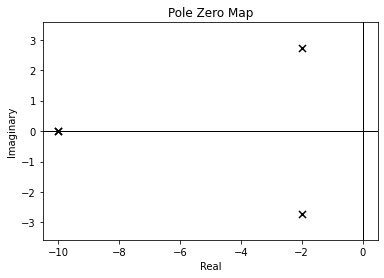

In [25]:
AClosedLoop = AClosedLoop.subs(gainsSub)
APlant = APlant.subs(measuredValues)
B = B.subs(measuredValues)
C = Matrix([[1, 0, 0, 0],
            [0, 0, 0, 0],
            [0, 0, 1, 0],
            [0, 0, 0, 0]])
D = Matrix([0,
            0,
            0,
            0])
initialStates = [0, # p1x (m)
                 0, # p1xdot (m/s)
                 3 * pi / 180, # theta (rad)
                 0] # thetadot (rad/sec) 
                        
sys = StateSpace(AClosedLoop, B, C, D)
fig1 = plt.figure()
p1 = pzmap(sys)

Text(0.5, 1.0, '\\{theta} vs t')

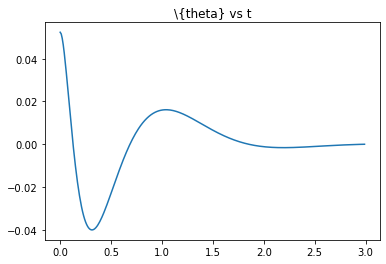

In [43]:
fig2 = plt.figure()
dt = 0.01
T = np.arange(0, 3, dt)
y, t = initial(sys, T, initialStates)

p1 = plt.plot(t, y[:, 2])
plt.title("\{theta} vs t")
